## Prediction Analysis for 'PM10' data

Here we will apply ARIMA modelling to predict the future data for PM10 concentration.

In [1]:
!pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import pandas.plotting
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
%matplotlib inline

In [3]:
file_path = 'C:/Users/Omkar/Desktop/EE798Q/Open pit blasting 01-02-2023 000000 To 01-05-2023 235959.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path , index_col=0)

In [4]:
# Simplify column names
df.columns = ['from', 'to', 'PM10', 'PM2.5', 'NO','NO2','NOX','CO','SO2','NH3','Ozone','Benzene']
# deleting to column as we need only one timestamp column for to be index and we choose it to be from column
df = df.drop('to', axis=1)
# removing last 3 rows as they contaion max , min , avg data instead of actual observations
df = df.iloc[:-3]
df.tail()


,from,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
#,,,,,,,,,,,
8636,2023-05-01 22:45:00,19.0,11.0,17.9,100.0,67.8,0.63,10.0,10.7,26.1,0.1
8637,2023-05-01 23:00:00,19.0,11.0,17.9,100.0,67.7,0.57,10.0,10.4,30.9,0.1
8638,2023-05-01 23:15:00,19.0,11.0,19.6,100.2,69.2,0.58,9.9,10.5,29.6,0.1
8639,2023-05-01 23:30:00,19.0,11.0,20.8,100.2,70.2,0.58,9.5,10.8,30.0,0.1
8640,2023-05-01 23:45:00,32.0,6.0,21.8,98.8,70.3,NaN,NaN,11.0,33.5,0.1


In [5]:
# conveting timestamp as a string object into a datetime numerical 
date_format = '%Y-%m-%d %H:%M:%S'

# Convert the 'from' column to numerical datetime representation
df['from'] = pd.to_datetime(df['from'], format=date_format)


In [6]:
# set datetime "from" column as an index column
df.set_index('from', inplace=True)
df.head()

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
from,,,,,,,,,,
2023-02-01 00:00:00,95.0,35.0,NaN,90.1,56.2,0.31,NaN,17.7,28.1,0.4
2023-02-01 00:15:00,95.0,35.0,NaN,88.0,55.1,0.33,NaN,18.3,27.1,0.4
2023-02-01 00:30:00,95.0,35.0,NaN,87.7,55.2,0.38,NaN,19.7,24.9,0.4
2023-02-01 00:45:00,122.0,34.0,NaN,88.9,55.7,0.38,NaN,21.3,21.9,0.4
2023-02-01 01:00:00,122.0,34.0,NaN,90.0,55.8,0.38,NaN,22.3,16.7,0.4


In [7]:
df3=df.copy()

In [8]:
p2=df3['PM10']

In [9]:
# resample
df3 = df3.resample('D').mean()
# interpolating
PM10 = df3['PM10']
df3 = df3.interpolate(method='spline',order=3)
df3.fillna(method='ffill', inplace=True)  # Fill missing values forward
df3.fillna(method='bfill', inplace=True)  # Fill missing values backward

In [10]:
df3.head()

,PM10,PM2.5,NO,NO2,NOX,CO,SO2,NH3,Ozone,Benzene
from,,,,,,,,,,
2023-02-01,114.739583,35.145833,10.622222,79.180645,48.821505,0.441183,10.244681,22.080851,30.076744,0.232292
2023-02-02,177.458333,52.020833,10.622222,79.286957,53.986957,1.303152,10.244681,22.266667,25.331183,0.120000
2023-02-03,171.270833,52.916667,10.622222,82.408602,56.936559,1.211075,10.244681,23.105319,27.535106,0.165625
2023-02-04,222.552941,74.651685,10.622222,76.781319,53.721978,1.146222,10.244681,25.094565,26.340659,0.184444
2023-02-05,271.354430,86.987952,10.622222,74.712048,66.445783,0.890357,10.244681,25.571429,21.824706,0.214286


Here we will take some part of our data as training set for ARIMA modelling while the remaing part will be predicted by the model. Then we will compare the actual data and the predicted data.

In [11]:
t=df3.index[70]
# msk = (df.index <= pd.to_datetime(t, format='%y-%m-%d %H:%M:%S'))
msk=(df3.index<=t)
df_train =df3['PM10'][msk].copy()
df_test = df3['PM10'][~msk].copy()

In [12]:
t

Timestamp('2023-04-12 00:00:00', freq='D')

In [13]:
# just checking code   ADF test to check for stationarity
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df3['PM10'])
print(f'p-value: {adf_test[1]}')

p-value: 0.004522349467992982


In [14]:
import pmdarima as pm
auto_arima = pm.auto_arima(df_train, stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(1, 0, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [15]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   71
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -409.341
Date:                Sun, 25 Jun 2023   AIC                            826.682
Time:                        19:44:37   BIC                            835.733
Sample:                    02-01-2023   HQIC                           830.282
                         - 04-12-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9702      0.029     33.392      0.000       0.913       1.027
ma.L1         -0.0254      0.089     -0.285      0.776      -0.200       0.149
ma.L2         -0.3680      0.095     -3.882      0.000      -0.554      -0.182
sigma2      5778.4197    628.213      9.198      0.000    4547.144    7009.695
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                27.84
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                             0.21
Prob(H) (two-sided):                  0.67   Kurtosis:                         6.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

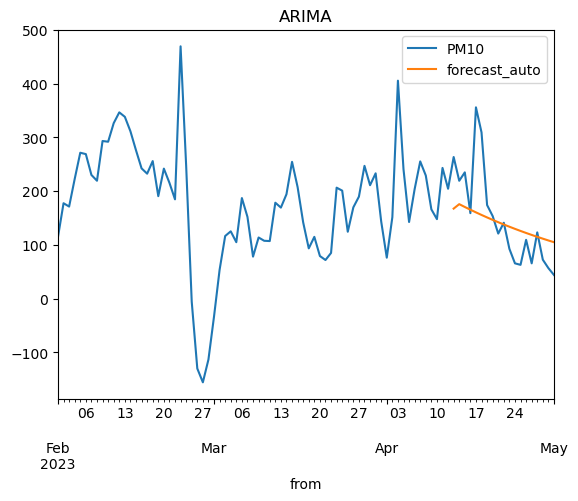

In [16]:
forecast_test_auto = auto_arima.predict(n_periods=len(df_test))
df3['forecast_auto'] = [None]*len(df_train) + list(forecast_test_auto)

columns_to_plot = ['PM10', 'forecast_auto']
%matplotlib inline
data_to_plot = df3[columns_to_plot]

data_to_plot.plot()
plt.title('ARIMA')
plt.show()

In the above plot forecast_auto is the prediction by ARIMA model.
Here we can observe that resampled data provides better forecasting than one without it.

Finally we will calculate error of prediction and actual data.

In [17]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

mae = mean_absolute_error(df_test, forecast_test_auto)
mape = mean_absolute_percentage_error(df_test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(df_test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 53.009429041707186
mape - auto: 0.44952142020881874
rmse - auto: 72.07877893064887
